# Interpretowalność sieci

In [11]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Model VGG16

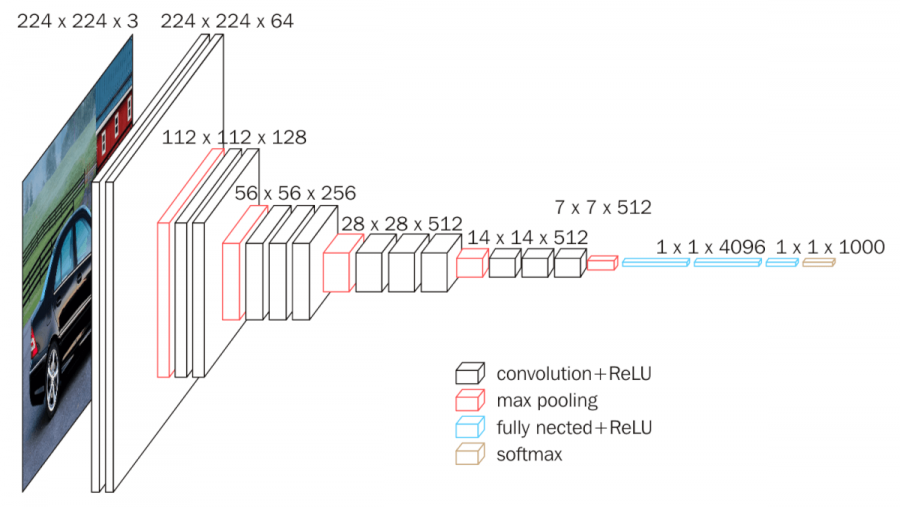

In [2]:
# load the model
model = VGG16()
display(load_img("vgg16.png"))

`VGG16` jest głęboką siecią konwolucyjną służącą do klasyfikacji kolorowych zdjęć ze zbioru `ImageNet`. Sieć ma na celu rozpoznanie obiektu przedstawionego na zdjęciu i przypisaniu mu jednego z tysiąca labeli. Jest on głównie wykorzystywany wraz z wcześniej trenowanymi wagami, pozwalając na szybkie wykorzystanie do analizy zdjęć.

*Źródło: https://neurohive.io/en/popular-networks/vgg16/*

## Analizowane zdjęcia

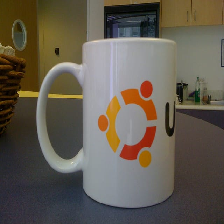

Result:
coffee_mug (69.98%)
coffeepot (10.57%)
cup (7.66%)


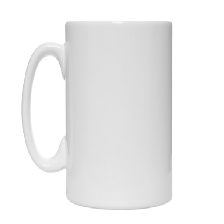

Result:
coffee_mug (61.14%)
cup (22.74%)
pitcher (5.91%)


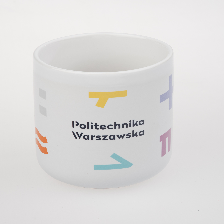

Result:
oil_filter (29.06%)
coffee_mug (19.62%)
measuring_cup (10.02%)


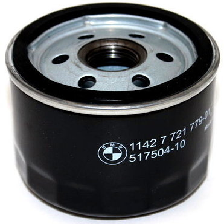

Result:
oil_filter (100.00%)
pencil_sharpener (0.00%)
puck (0.00%)


In [3]:
labels = {}
def preprocessImage(img, preview=False):
    # load and prepare the image
    image = load_img(img, target_size=(224, 224))
    if(preview):
        display(image)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

def describeImage(img):
    # load and prepare the image
    image = preprocessImage(img, True)

    # predict what the image depicts
    yhat = model.predict(image)
    label = decode_predictions(yhat)
    label = label[0]

    # print the results
    print("Result:")
    labels[img] = []
    for i in range(0, 3):
        labels[img].append('%s (%.2f%%)' % (label[i][1], label[i][2]*100))
        print(labels[img][i])
        
describeImage("different_mug.jpg")
describeImage("blank_mug.jpg")
describeImage("mug.jpg")
describeImage("oil_filter.jpg")

Będziemy analizować wyniki sieci na podstawie trzech zdjęć - jasnego kubka na ciemnym tle, na jasnym tle oraz na jasnym tle ale obróconym tak, że nie widać rączki. Dla porównania weźmiemy także pod uwagę zdjęcie z filtrem oleju.   
Dla pierwszego ze zdjęć widzimy dużą pewność że jest to właśnie kubek do kawy. Dla drugiego zdjecia pewność ta jest mniejsza, ale nadal bardzo duża. Natomiast trzecie zdjęcie klasyfikowane jest jak filtr oleju, z kubkiem będącym drugą proponowaną klasą. W ostatnim zdjęciu należy zwrócić uwagę na to, że model zwraca klasa z praktycznie 100% pewnością. Zatem niewykluczone, że to zdjęcie było wykorzystywane podczas treningu.

## Grad-CAM

In [14]:
def get_top_predicted_indices(predictions, top_n):
    return np.argsort(-predictions).squeeze()[:top_n]

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names,
    top_n,
    class_indices
):
    #1. Create a model that maps the input image to the activations of the last convolution layer - Get last conv layer's output dimensions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    #2. Create another model, that maps from last convolution layer to the final class predictions - This is the classifier model that calculated the gradient
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    #3. If top N predictions are to be interospected, Get their Imagenet indices else assign the indices given
    if(top_n > 0):
        last_conv_layer_output = last_conv_layer_model(img_array)
        preds = classifier_model(last_conv_layer_output)
        class_indices = get_top_predicted_indices(preds, top_n)
    else:
        top_n = len(class_indices)
    
    #4. Create an array to store the heatmaps
    heatmaps = []
    #5. Iteratively calculate heatmaps for all classes of interest using GradientTape
    for index in np.arange(top_n):
    
        #6. Watch the last convolution output during the prediction process to calculate the gradients
        #7. Compute the activations of last conv layer and make the tape to watch
        with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)

            #8. Get the class predictions and the class channel using the class index
            preds = classifier_model(last_conv_layer_output)
            class_channel = preds[:, class_indices[index]]
            
        #9. Using tape, Get the gradient for the predicted class wrt the output feature map of last conv layer    
        grads = tape.gradient(
            class_channel,
            last_conv_layer_output
        )
        
        #10. Calculate the mean intensity of the gradient over its feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))    
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        
        #11. Multiply each channel in feature map array by weight importance of the channel
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        #12. The channel-wise mean of the resulting feature map is our heatmap of class activation
        heatmap = np.mean(last_conv_layer_output, axis=-1)

        #13. Normalize the heatmap between [0, 1] for ease of visualization
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        heatmaps.append({
            "class_id": class_indices[index],
            "heatmap": heatmap
        })

    return heatmaps

def superimpose_heatmap(image_path, heatmap):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    
    heatmap = keras.preprocessing.image.img_to_array(heatmap)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    superimposed_img = np.uint8(superimposed_img)
    
    return superimposed_img

def display_superimposed_heatmaps(heatmaps, image_path, image_id, labels):
    n = len(heatmaps)
    n_rows = (n // 3) + 1 if n % 3 > 0 else n // 3
    plt.rcParams['axes.grid'] = False
    plt.rcParams['xtick.labelsize'] = False
    plt.rcParams['ytick.labelsize'] = False
    plt.rcParams['xtick.top'] = False
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    plt.rcParams['ytick.right'] = False
    plt.rcParams['figure.figsize'] = [30, 15]
    for index in np.arange(n):
        heatmap = heatmaps[index]["heatmap"]
        superimposed_image = superimpose_heatmap(image_path, heatmap)
        plt.subplot(n_rows, 3, index+1)
        plt.title(f"{labels[index]}", fontsize= 30)
        plt.imshow(superimposed_image)
    plt.show()
       
def gradcam_imager(img):
    heatmaps = make_gradcam_heatmap(
        get_img_array(img, (224, 224)), 
        model, 
        "block5_conv3", 
        ["block5_pool", "flatten", "fc1", "fc2", "predictions"], 
        3, 
        None
    )
    display_superimposed_heatmaps(heatmaps, img, 1, labels[img])

*Źródło: https://www.kaggle.com/gowrishankarin/gradcam-model-interpretability-vgg16-xception*

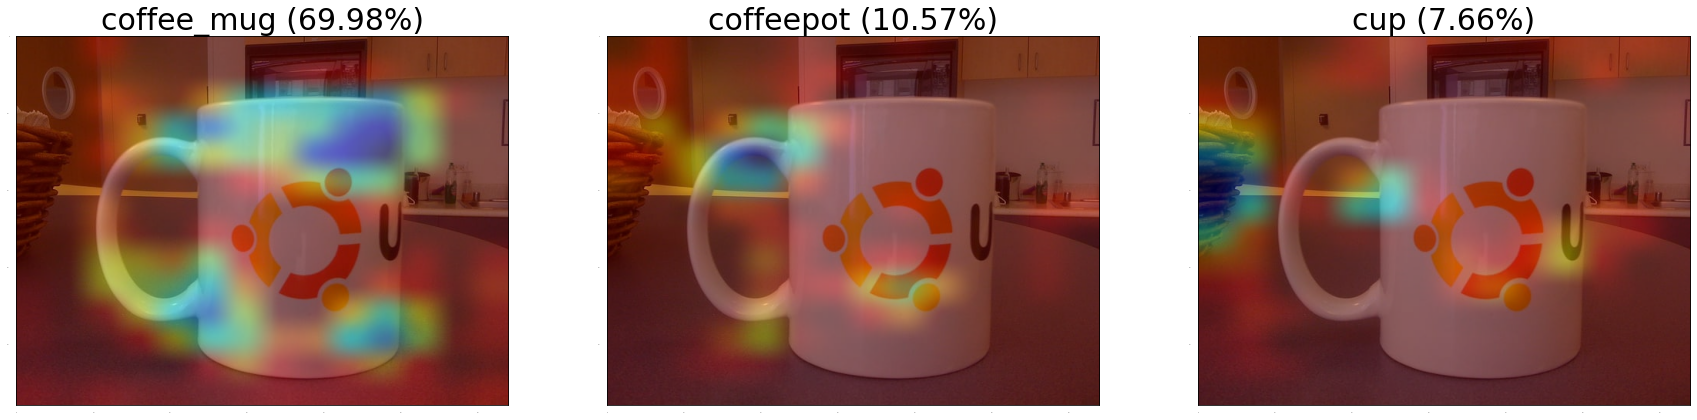

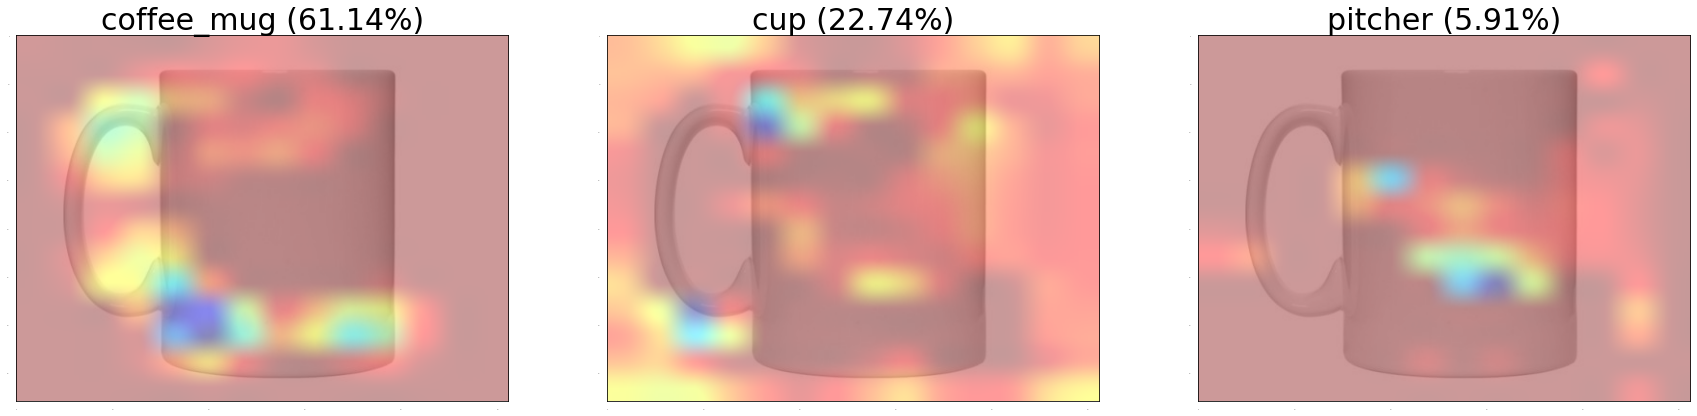

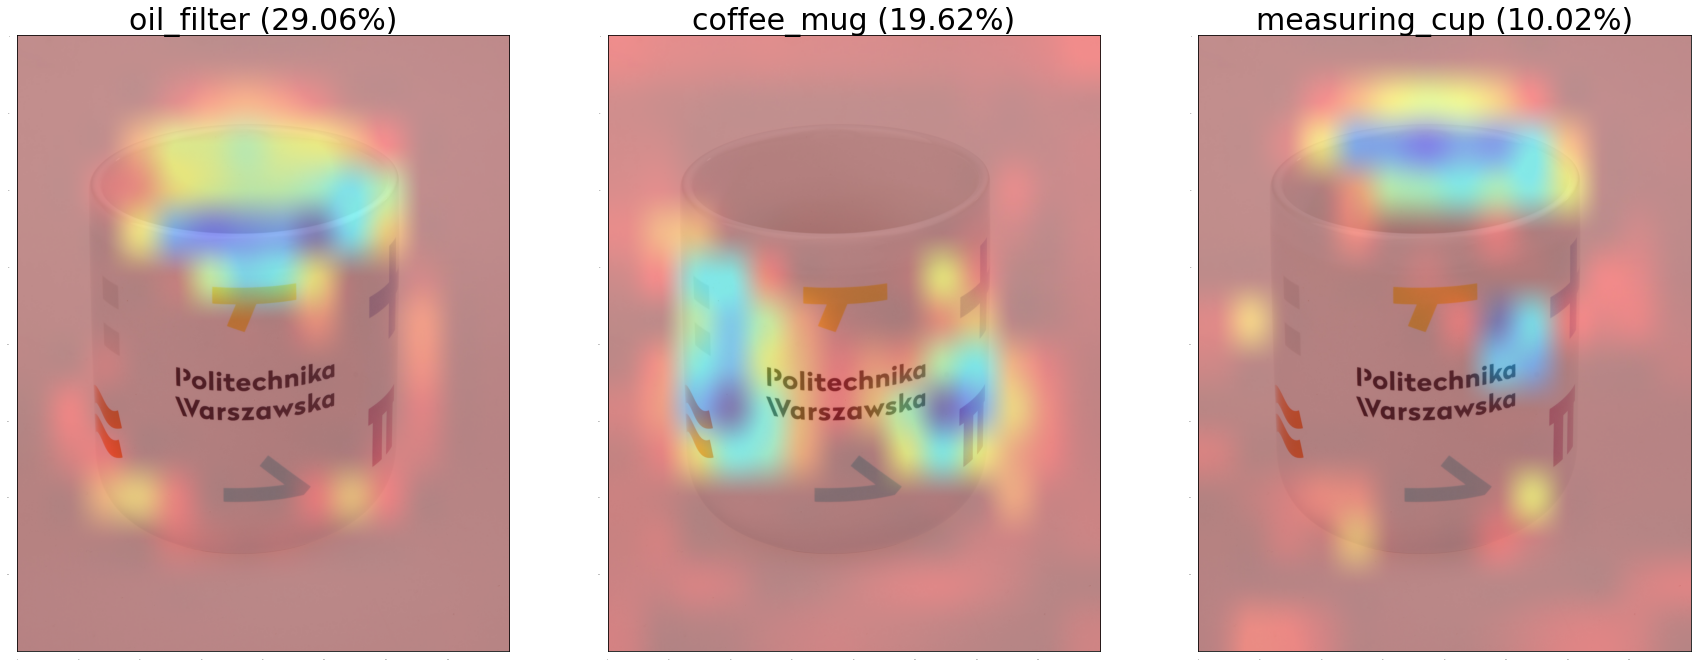

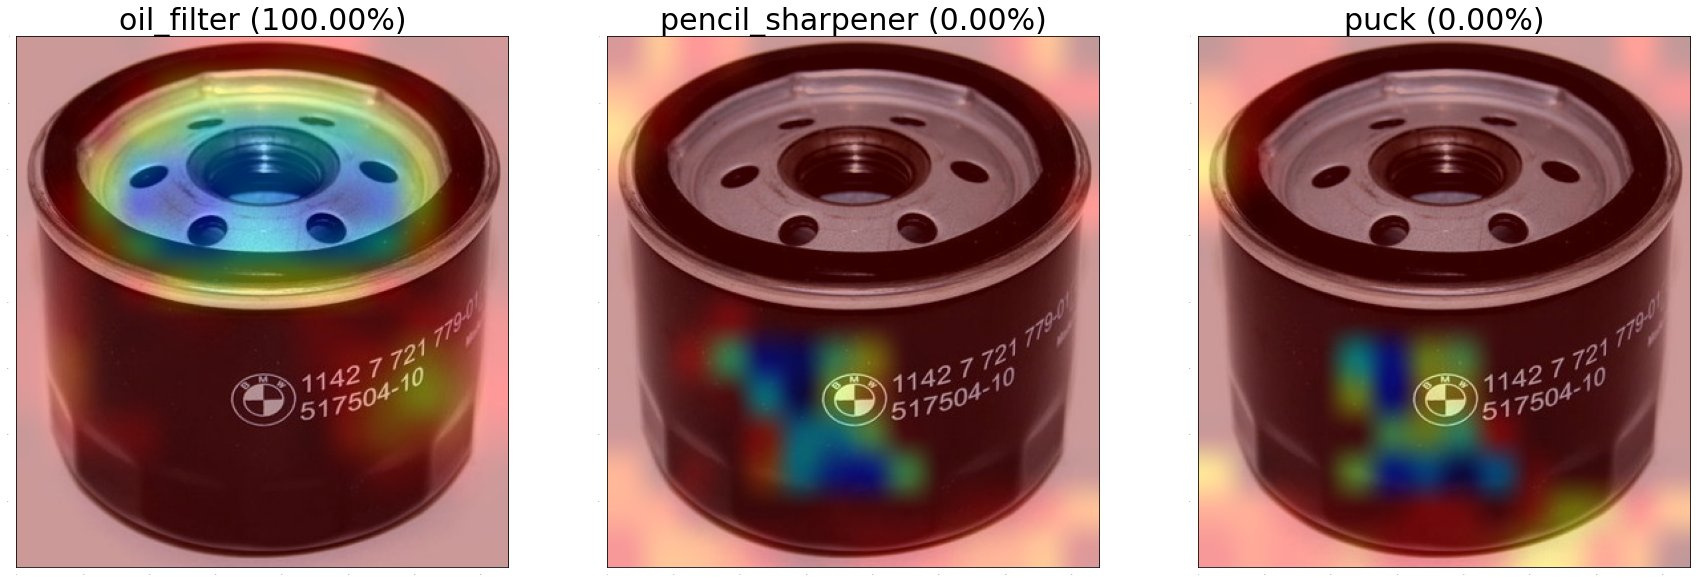

In [15]:
gradcam_imager("different_mug.jpg")
gradcam_imager("blank_mug.jpg")
gradcam_imager("mug.jpg")
gradcam_imager("oil_filter.jpg")

W przypadku pierwszych dwóch zdjęć widać duże znaczenie rączki w klasyfikacji obiektu. W trzecim zdjęciu rączka ta nie jest widoczna na zdjęciu, dlatego model miał większy problem z poprawnym skategoryzowaniem tego zdjęcia.   

Widać tutaj także że w przypadku filtru najważniejszą częścią dla sieci jest górna powierzchnia. W przypadku zdjęcia trzeciego, nie tylko kształt tej powierzchni jest podobny (nie uwzględniając dodatkowych elementów w środku), ale także kąt pod którym zdjęcie było robione jest podobny do tego ze zdjęcia czwartego. To może tłumaczyć błędną klasyfikację jako filtr oleju.

## Lime

In [31]:
def display_image_grid(images, labels):
    n = len(images)
    n_rows = (n // 3) + 1 if n % 3 > 0 else n // 3
    plt.rcParams['axes.grid'] = False
    plt.rcParams['xtick.labelsize'] = False
    plt.rcParams['ytick.labelsize'] = False
    plt.rcParams['xtick.top'] = False
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    plt.rcParams['ytick.right'] = False
    plt.rcParams['figure.figsize'] = [30, 15]
    for index in np.arange(n):
        plt.subplot(n_rows, 3, index+1)
        plt.title(f"{labels[index]}", fontsize= 30)
        plt.imshow(images[index])
    plt.show()

def lime_explainer(img): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_to_array(load_img(img, target_size=(224, 224))).astype('double'), model.predict, top_labels=3, hide_color=0, num_samples=1000)
    
    explanations = []
    for i in range(3):
        source, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=True, num_features=5, hide_rest=True)
        explanations.append(np.clip(mark_boundaries(source / 2 + 0.4, mask), 0, 1))
    display_image_grid(explanations, labels[img])

  0%|          | 0/1000 [00:00<?, ?it/s]

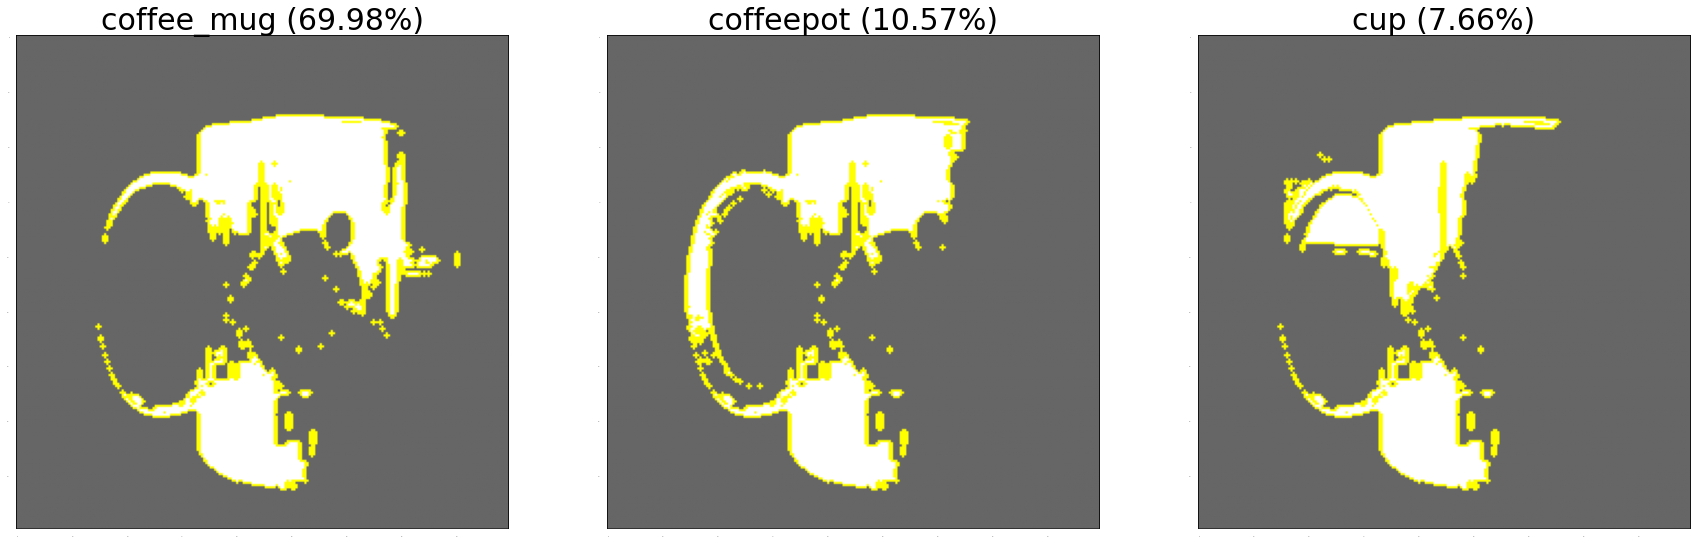

  0%|          | 0/1000 [00:00<?, ?it/s]

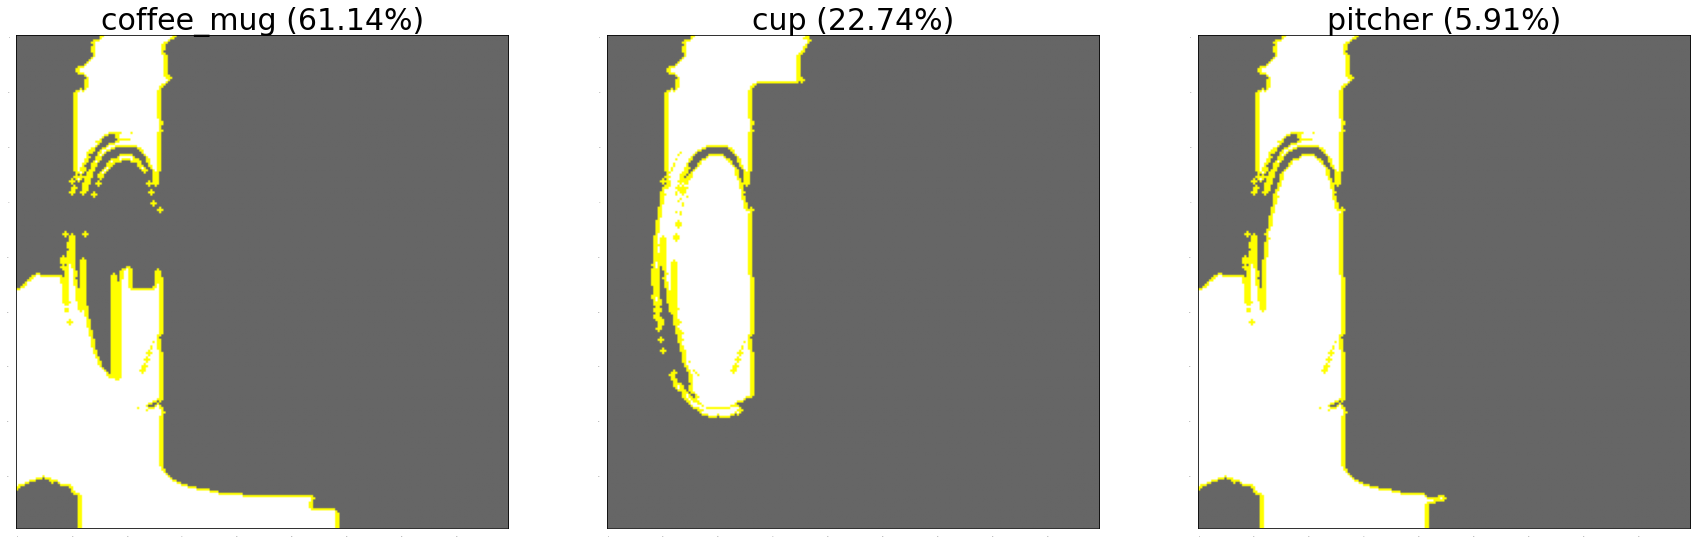

  0%|          | 0/1000 [00:00<?, ?it/s]

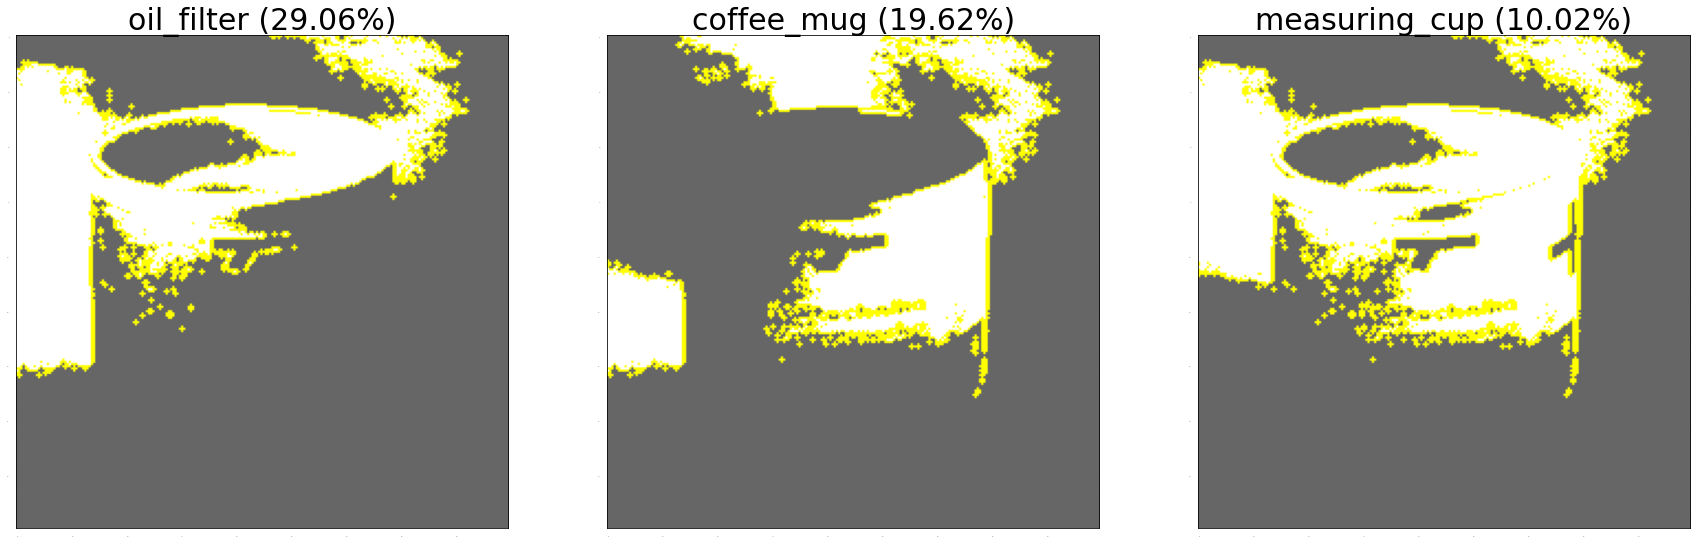

  0%|          | 0/1000 [00:00<?, ?it/s]

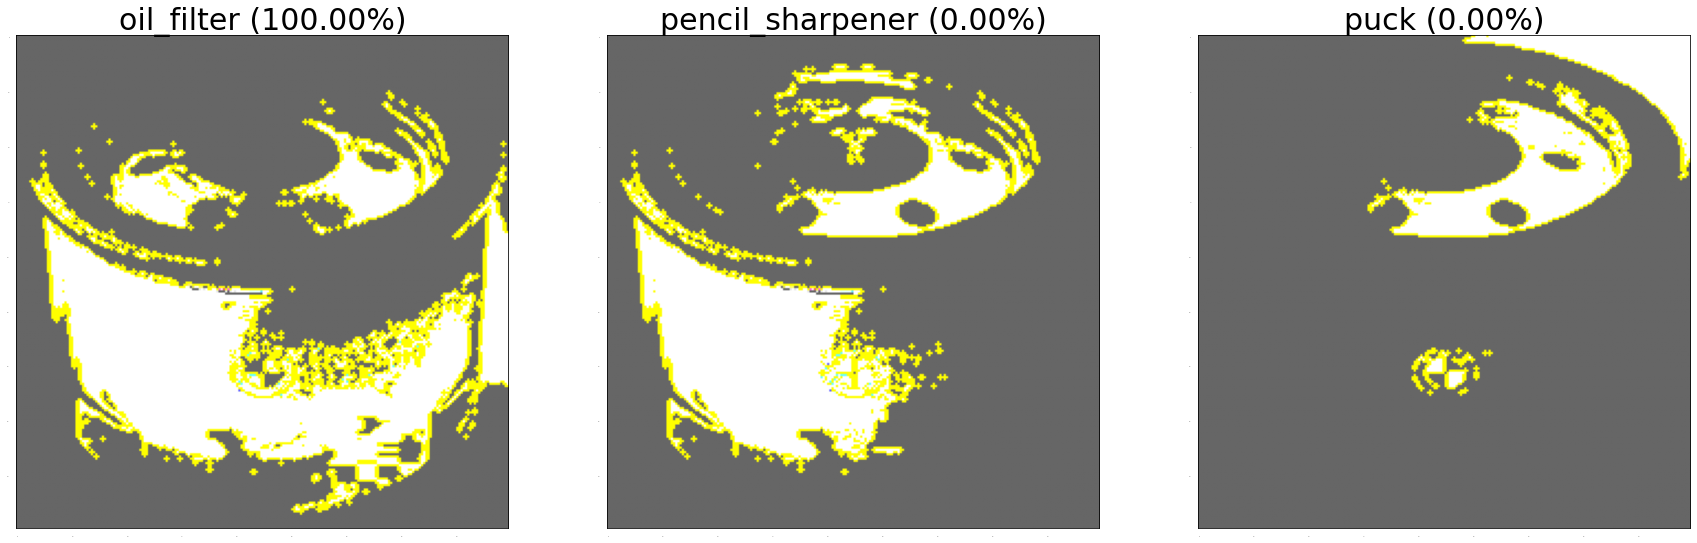

In [32]:
lime_explainer("different_mug.jpg")
lime_explainer("blank_mug.jpg")
lime_explainer("mug.jpg")
lime_explainer("oil_filter.jpg")

Na tej analizie obserwujemy to bardzo podobne zachowanie jak dla grad-CAM. W pierwszych dwóch zdjęciach najważniejszą cechą dla modelu jest rączka od kubka. Na zdjęciu trzecim nie jest ona widoczna, więc model skupia się na cylindrycznym kształcie obiektu, w szczególności analizując górną powierzchnie.    

Jednak najciekawszy rezultat ukazał się dla zdjęcia czwartego. W przeciwieństwie do analizy grad-CAM, tutaj widzimy większe skupienie się na przedniej części obiektu. W przypadku analizy lime trudniej jest znaleźć uzasadnienie, czemu zdjęcie trzecie zostało zklasyfikowane jako filtr oleju, jednak nadal można zakładać że jest to spowodowane podobnym kształtem i kątem pod którym zdjęcie zostało zrobione